In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
#sys.path.insert(0, '/Users/ammar.tareen/Desktop/Research_projects/mavenn2/')
sys.path.insert(0, '/Users/tareen/Desktop/Research_Projects/2022_mavenn2_github/mavenn')

import mavenn
import logomaker
import seaborn as sns
import re

%matplotlib inline

In [2]:
# # Load example data
# data_df = mavenn.load_example_dataset('sortseq')

# # Separate test from data_df
# ix_test = data_df['set']=='test'
# test_df = data_df[ix_test].reset_index(drop=True)
# print(f'test N: {len(test_df):,}')

# # Remove test data from data_df
# data_df = data_df[~ix_test].reset_index(drop=True)
# print(f'training + validation N: {len(data_df):,}')
# data_df.head()
#pd.read_csv
data_df_full = pd.read_csv('../data/2022.05.15.ace2rbd/ace2rbd_raw_counts_lib1.csv')
data_df = data_df_full[['x','SortSeq_bin1','SortSeq_bin2','SortSeq_bin3','SortSeq_bin4']].copy()
data_df.head(10)

,x,SortSeq_bin1,SortSeq_bin2,SortSeq_bin3,SortSeq_bin4
0,NITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFST...,0,0,0,0
1,NITNLCPFGEVFSATRFASVYAWNRKRISNCVADYSVLYNSASFST...,116,92,21,3
2,NITNLCPFGEVFNATRFASVYCWNRKRISNCVADYSVLYNSASFST...,158,120,137,15
3,NITNLCPFGEVFFATRFASVYAWNRKRISNCVADYSVLYNSASFST...,47,234,521,116
4,NITNLKPFGEVFNAWRFASVYAWNRKRISNCVADYSVLYNSASFST...,299,32,1,1
5,NITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFST...,322,238,196,14
6,NITNLCPFGEVFNATRFVSVYAWNRKRISNCVADYSVLYNSASFST...,38,78,181,45
7,NITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFST...,1364,24,43,15
8,NITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFST...,64,129,122,27
9,NITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFST...,0,0,6,22


In [3]:
y_cols = data_df.columns[1:]

X = data_df['x']
y = data_df[y_cols]

In [4]:
from sklearn.model_selection import train_test_split

# split data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

In [5]:
# set positional argumnets for gpmap function
L = len(data_df['x'][0])
alphabet_star=['A', 'C', 'D', 'E', 'F',
              'G', 'H', 'I', 'K', 'L',
              'M', 'N', 'P', 'Q', 'R',
              'S', 'T', 'V', 'W', 'Y','*']

alphabet=['A', 'C', 'D', 'E', 'F',
          'G', 'H', 'I', 'K', 'L',
          'M', 'N', 'P', 'Q', 'R',
          'S', 'T', 'V', 'W', 'Y']


Y = len(y_cols)
print(f'L={L}, Y={Y}')

L=201, Y=4


In [6]:
# instantiate gpmap object
gpmap = mavenn.gpmap.AdditiveGPMapLayer(L, alphabet)


2022-10-02 17:30:30.910412: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Create measurement process object(s)

In [7]:
# I think this shouldn't require any positional arguments.
# mp_GE = mavenn.measurement_process_layers.GlobalEpistasisLayer(K=50,
#                                                                eta=1e-5,
#                                                                monotonic=True)
mp_mpa = mavenn.measurement_process_layers.DiscreteMonotonicMP(info_for_layers_dict={'H_y_norm':0},
                                                                      Y=Y,
                                                                      K=50,
                                                                      eta=1e-5,)


In [8]:
model = mavenn.Model2(gpmap=gpmap,
                      mp_list=[mp_mpa])

In [9]:
model.model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Sequence_labels_input (InputLa  [(None, 4024)]      0           []                               
 yer)                                                                                             
                                                                                                  
 Sequence_only (Lambda)         (None, 4020)         0           ['Sequence_labels_input[0][0]']  
                                                                                                  
 additive_gp_map_layer (Additiv  (None, 1)           4021        ['Sequence_only[0][0]']          
 eGPMapLayer)                                                                                     
                                                                                              

In [10]:
# Set training data
model.set_data(x=x_train.values,
               y_list=[y_train.values],
               #validation_flags=(data_df['set']=='validation'),
               shuffle=True)


N = 83,880 observations set as training data.
Using 19.9% for validation.
Data shuffled.
Time to set data: 13.7 sec.


In [11]:

# Fit model to data
model.fit(learning_rate=.0005,
          epochs=150,
          batch_size=300,
          try_tqdm = False,
          early_stopping=True,
          early_stopping_patience=10,
          linear_initialization=False)

Epoch 1/150
225/225 [==============================] - 5s 16ms/step - loss: 219464.9062 - I_var: -0.0099 - val_loss: 218891.8281 - val_I_var: -0.0052
Epoch 2/150
225/225 [==============================] - 2s 9ms/step - loss: 218282.6875 - I_var: 9.4983e-05 - val_loss: 218872.3906 - val_I_var: -0.0050
Epoch 3/150
225/225 [==============================] - 2s 9ms/step - loss: 218189.5156 - I_var: 5.4047e-04 - val_loss: 218603.2500 - val_I_var: -0.0026
Epoch 4/150
225/225 [==============================] - 2s 10ms/step - loss: 217688.9219 - I_var: 0.0049 - val_loss: 218757.7031 - val_I_var: -0.0037
Epoch 5/150
225/225 [==============================] - 2s 9ms/step - loss: 216198.1094 - I_var: 0.0181 - val_loss: 216214.0000 - val_I_var: 0.0180
Epoch 6/150
225/225 [==============================] - 2s 8ms/step - loss: 212957.4688 - I_var: 0.0457 - val_loss: 213854.2344 - val_I_var: 0.0386
Epoch 7/150
225/225 [==============================] - 2s 9ms/step - loss: 208372.8438 - I_var: 0.0850 

225/225 [==============================] - 1s 6ms/step - loss: 190294.2031 - I_var: 0.2413 - val_loss: 194168.9688 - val_I_var: 0.2077
Epoch 57/150
225/225 [==============================] - 2s 7ms/step - loss: 190301.6875 - I_var: 0.2414 - val_loss: 194155.6562 - val_I_var: 0.2079
Epoch 58/150
225/225 [==============================] - 2s 7ms/step - loss: 190295.5938 - I_var: 0.2414 - val_loss: 194287.2812 - val_I_var: 0.2066
Epoch 59/150
225/225 [==============================] - 2s 7ms/step - loss: 190449.8438 - I_var: 0.2390 - val_loss: 194830.7969 - val_I_var: 0.2019
Epoch 60/150
225/225 [==============================] - 2s 7ms/step - loss: 190390.1250 - I_var: 0.2408 - val_loss: 194135.0000 - val_I_var: 0.2080
Epoch 61/150
225/225 [==============================] - 2s 7ms/step - loss: 190343.9375 - I_var: 0.2405 - val_loss: 194497.4844 - val_I_var: 0.2048
Epoch 62/150
225/225 [==============================] - 2s 7ms/step - loss: 190476.2031 - I_var: 0.2403 - val_loss: 194108.42

In [12]:
x_test

83963    NITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVFVNSASFST...
59559    NITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFST...
65011    NITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFST...
88527    NITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFST...
2806     NITNLCPFGEVFNVTRFASVYAWNRKRISNCVADYSVLYNSASFKT...
                               ...                        
81925    NITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFST...
21565    NITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFST...
58591    NITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFST...
18570    NIYNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFST...
41267    NITNLCPFGEVFNATRFASVYNWNRKRISNCVADYSVLYNSASFST...
Name: x, Length: 9321, dtype: object

On test data:


Text(0.5, 1.0, 'training hisotry')

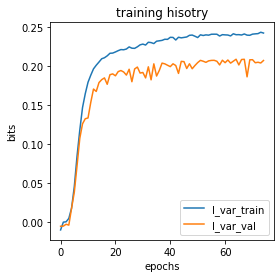

In [13]:
# Show training history
print('On test data:')

I_var_hist = model.history['I_var']
val_I_var_hist = model.history['val_I_var']

fig, ax = plt.subplots(1,1,figsize=[4,4])
ax.plot(I_var_hist, label='I_var_train')
ax.plot(val_I_var_hist, label='I_var_val')
ax.legend()
ax.set_xlabel('epochs')
ax.set_ylabel('bits')
ax.set_title('training hisotry')

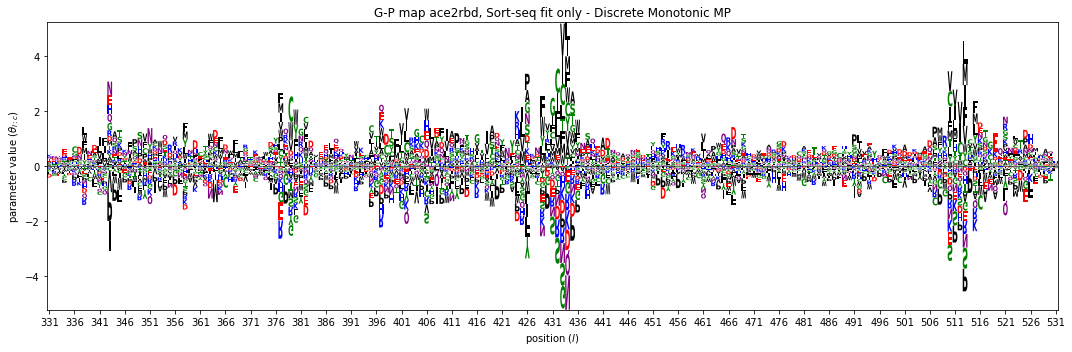

In [14]:
# Get G-P map parameters in matrix form
theta = np.squeeze(gpmap.weights[1].numpy())

# Create grid in phi space
phi_lim = [-5, 3]
phi_grid = np.linspace(phi_lim[0], phi_lim[1], 1000)

# Create array of allowable y values
Y = mp_mpa.Y    # Y = number of bins
y_lim = [-.5, Y-.5]
y_all = range(Y)

# Compute matrix of p(y|phi) values
#measurement_process = mp_mpa.p_of_y_given_phi(y_all, phi_grid)

# Create figure with two panels
fig, axs = plt.subplots(1,1,figsize=[15,5])

# Left panel: draw logo using logomaker
ax = axs
logo = logomaker.Logo(pd.DataFrame(theta,columns=model.alphabet), ax=ax,center_values=True, color_scheme='chemistry')
ax.set_ylabel(r'parameter value ($\theta_{l:c}$)')
ax.set_xlabel(r'position ($l$)')
ax.set_title('G-P map ace2rbd, Sort-seq fit only - Discrete Monotonic MP')
ax.set_xticks(np.arange(0,201,5))
ax.set_xticklabels([f'{x}' for x in range(331,531+1,5)])

# Right panel: draw measurement process as heatmap
# ax = axs[1]
# im = ax.imshow(measurement_process,
#                cmap='Greens',
#                extent=phi_lim+y_lim,
#                vmin=0,
#                origin='lower',
#                interpolation='nearest',
#                aspect="auto")
# ax.set_yticks(y_all)
# ax.set_ylabel('bin number (y)')
# ax.set_xlabel('latent phenotype ($\phi$)')
# ax.set_title('measurement process')
# cb = plt.colorbar(im)
# cb.set_label('probability  $p(y|\phi)$', rotation=-90, va="bottom")

# Fix up plot
fig.tight_layout()
fig.savefig('ace2rbd_g-p_map_mpa_sortseq_only.png',dpi=300,bbox_inches='tight')
plt.show()

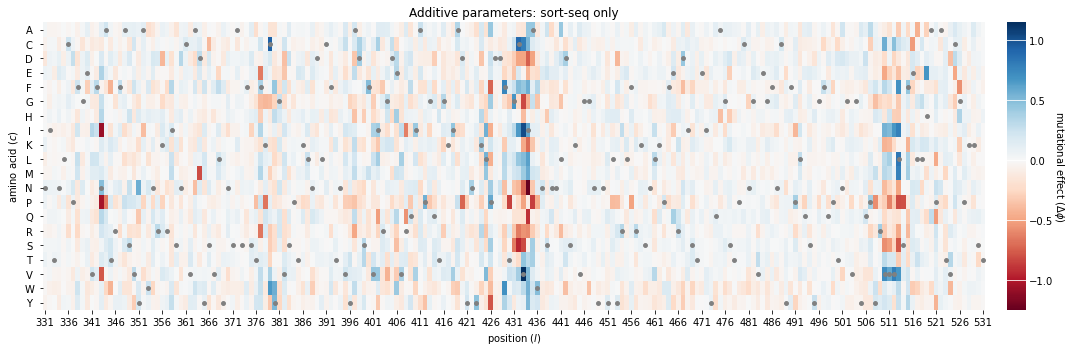

In [15]:
# Create figure
fig, ax = plt.subplots(1,1, figsize=(15,5))

# Draw heatmap
heatmap_ax, cb = mavenn.heatmap(ax=ax,
                                values=logo.df.values,
                                alphabet=alphabet,
                                seq=model.x_stats['consensus_seq'],
                                seq_kwargs={'c':'gray', 's':15},
                                cmap='RdBu',
                                cbar=True,
                                cmap_size='2%',
                                cmap_pad=.3,
                                ccenter=0)
# Style heatmap (can be different between two dataset)
#heatmap_ax.set_xticks()
heatmap_ax.tick_params(axis='y', which='major', pad=10)
heatmap_ax.set_xlabel('position ($l$)')
heatmap_ax.set_ylabel('amino acid ($c$)')
heatmap_ax.set_title(f'Additive parameters: sort-seq only')
heatmap_ax.set_xticks(np.arange(0,201,5))
heatmap_ax.set_xticklabels([f'{x}' for x in range(331,531+1,5)])

# Style colorbar
cb.outline.set_visible(False)
cb.ax.tick_params(direction='in', size=20, color='white')
cb.set_label('mutational effect ($\Delta \phi$)', labelpad=5, rotation=-90, ha='center', va='center')

# Adjust figure and show
fig.tight_layout(w_pad=5)
fig.savefig('ace2rbd_g-p_map_mpa_sortseq_only_heatmap.png',dpi=300,bbox_inches='tight')

In [16]:
bloom_single_mut_df = pd.read_csv('single_mut_effects_Bloom.txt')
bloom_single_mut_df.head(10)

,site_RBD,site_SARS2,wildtype,mutant,mutation,mutation_RBD,bind_lib1,bind_lib2,bind_avg,expr_lib1,expr_lib2,expr_avg
0,1,331,N,A,N331A,N1A,-0.05,-0.02,-0.03,-0.14,-0.08,-0.11
1,1,331,N,C,N331C,N1C,-0.08,-0.10,-0.09,-1.56,-0.97,-1.26
2,1,331,N,D,N331D,N1D,0.00,0.07,0.03,-0.75,-0.12,-0.44
3,1,331,N,E,N331E,N1E,0.02,-0.02,0.00,-0.39,-0.24,-0.31
4,1,331,N,F,N331F,N1F,-0.03,-0.16,-0.10,-0.83,-0.57,-0.70
5,1,331,N,G,N331G,N1G,-0.06,-0.02,-0.04,-0.21,-0.29,-0.25
6,1,331,N,H,N331H,N1H,0.01,-0.05,-0.02,-0.86,-0.36,-0.61
7,1,331,N,I,N331I,N1I,-0.06,-0.08,-0.07,-1.05,-0.65,-0.85
8,1,331,N,K,N331K,N1K,-0.01,-0.01,-0.01,-0.17,-0.24,-0.20
9,1,331,N,L,N331L,N1L,-0.08,-0.01,-0.05,-0.81,-0.69,-0.75


In [17]:

bloom_exp_df = pd.DataFrame(columns=alphabet)
for site in range(1,201+1,):

    temp_df = bloom_single_mut_df[bloom_single_mut_df['site_RBD']==site].copy()
    temp_df['expr_lib1']
    bloom_exp_df.loc[site-1] = temp_df['expr_lib1'].values[0:20]




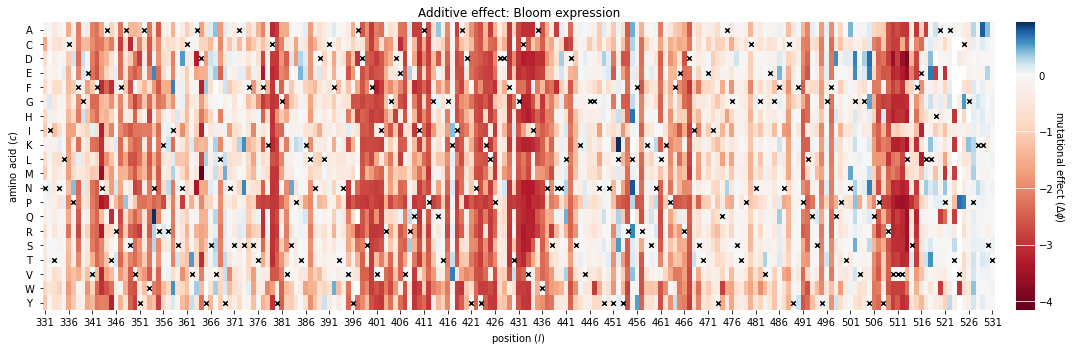

In [18]:
bloom_exp_df
# Create figure
fig, ax = plt.subplots(1,1, figsize=(15,5))

# Draw heatmap
heatmap_ax, cb = mavenn.heatmap(ax=ax,
                                values=bloom_exp_df.values,
                                alphabet=alphabet,
                                seq=model.x_stats['consensus_seq'],
                                seq_kwargs={'c':'black', 's':20,'marker':'x'},
                                cmap='RdBu',
                                cbar=True,
                                cmap_size='2%',
                                cmap_pad=.3,
                                ccenter=0)
# Style heatmap (can be different between two dataset)
#heatmap_ax.set_xticks()
heatmap_ax.tick_params(axis='y', which='major', pad=10)
heatmap_ax.set_xlabel('position ($l$)')
heatmap_ax.set_ylabel('amino acid ($c$)')
heatmap_ax.set_title(f'Additive effect: Bloom expression')

heatmap_ax.set_xticks(np.arange(0,201,5))
heatmap_ax.set_xticklabels([f'{x}' for x in range(331,531+1,5)])

# Style colorbar
cb.outline.set_visible(False)
cb.ax.tick_params(direction='in', size=20, color='white')
cb.set_label('mutational effect ($\Delta \phi$)', labelpad=5, rotation=-90, ha='center', va='center')

# Adjust figure and show
fig.tight_layout(w_pad=5)
#fig.savefig('ace2rbd_g-p_map_mpa_sortseq_only_heatmap.png',dpi=300,bbox_inches='tight')

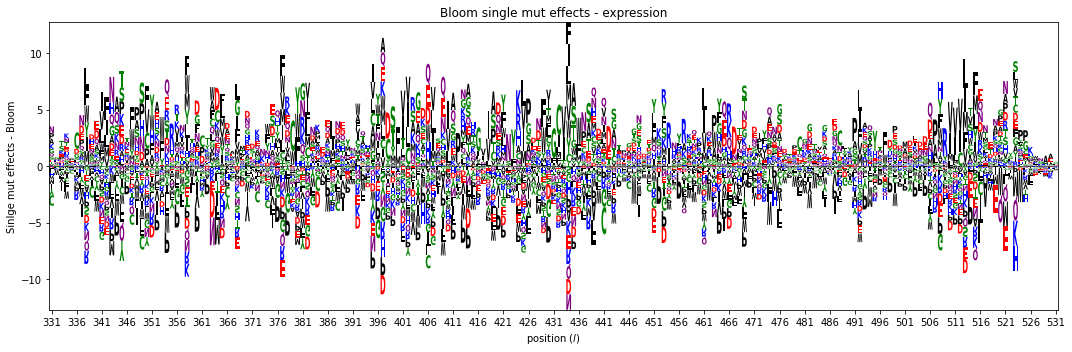

In [19]:
# Get G-P map parameters in matrix form
theta = np.squeeze(gpmap.weights[1].numpy())

# Create grid in phi space
phi_lim = [-5, 3]
phi_grid = np.linspace(phi_lim[0], phi_lim[1], 1000)

# Create array of allowable y values
Y = mp_mpa.Y    # Y = number of bins
y_lim = [-.5, Y-.5]
y_all = range(Y)

# Compute matrix of p(y|phi) values
#measurement_process = mp_mpa.p_of_y_given_phi(y_all, phi_grid)

# Create figure with two panels
fig, axs = plt.subplots(1,1,figsize=[15,5])

# Left panel: draw logo using logomaker
ax = axs
logo = logomaker.Logo(bloom_exp_df.fillna(0), ax=ax,center_values=True, color_scheme='chemistry')
ax.set_ylabel('Sinlge mut effects - Bloom')
ax.set_xlabel(r'position ($l$)')
ax.set_title('Bloom single mut effects - expression')
ax.set_xticks(np.arange(0,201,5))
ax.set_xticklabels([f'{x}' for x in range(331,531+1,5)])

# Right panel: draw measurement process as heatmap
# ax = axs[1]
# im = ax.imshow(measurement_process,
#                cmap='Greens',
#                extent=phi_lim+y_lim,
#                vmin=0,
#                origin='lower',
#                interpolation='nearest',
#                aspect="auto")
# ax.set_yticks(y_all)
# ax.set_ylabel('bin number (y)')
# ax.set_xlabel('latent phenotype ($\phi$)')
# ax.set_title('measurement process')
# cb = plt.colorbar(im)
# cb.set_label('probability  $p(y|\phi)$', rotation=-90, va="bottom")

# Fix up plot
fig.tight_layout()
#fig.savefig('ace2rbd_g-p_map_mpa_sortseq_only.png',dpi=300,bbox_inches='tight')
plt.show()

In [20]:
theta

array([[ 0.0159323 , -0.06925861, -0.15736708, ..., -0.02068677,
        -0.03089413, -0.06792841],
       [-0.05565539, -0.00479105,  0.03537672, ..., -0.00578671,
        -0.0845914 , -0.03476859],
       [-0.20682745, -0.1494961 , -0.1340685 , ..., -0.20393036,
        -0.25029418, -0.16376232],
       ...,
       [ 0.22764656,  0.1516144 ,  0.11691889, ...,  0.06680915,
         0.12869167,  0.03785717],
       [ 0.15884352,  0.10002797,  0.14717253, ...,  0.16886462,
         0.15390442,  0.08070921],
       [-0.02501317, -0.01848155, -0.01587824, ..., -0.00254641,
        -0.01854379, -0.04644169]], dtype=float32)

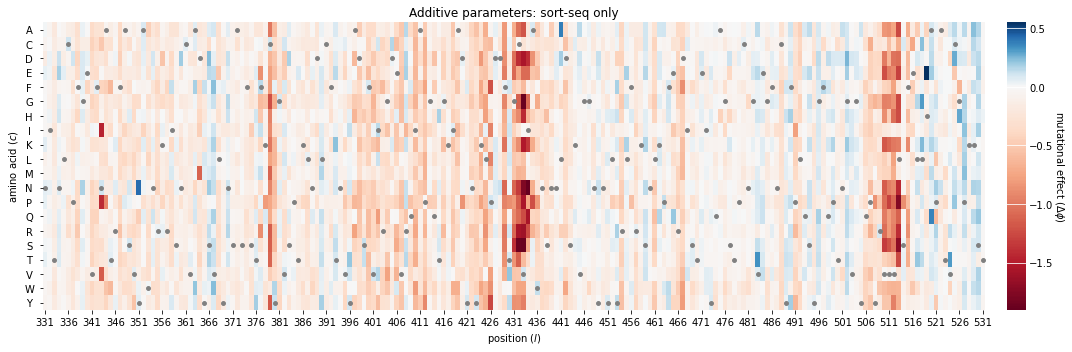

In [21]:
# Create figure
fig, ax = plt.subplots(1,1, figsize=(15,5))

# Draw heatmap
heatmap_ax, cb = mavenn.heatmap(ax=ax,
                                values=theta,
                                alphabet=alphabet,
                                seq=model.x_stats['consensus_seq'],
                                seq_kwargs={'c':'gray', 's':15},
                                cmap='RdBu',
                                cbar=True,
                                cmap_size='2%',
                                cmap_pad=.3,
                                ccenter=0)
# Style heatmap (can be different between two dataset)
#heatmap_ax.set_xticks()
heatmap_ax.tick_params(axis='y', which='major', pad=10)
heatmap_ax.set_xlabel('position ($l$)')
heatmap_ax.set_ylabel('amino acid ($c$)')
heatmap_ax.set_title(f'Additive parameters: sort-seq only')
heatmap_ax.set_xticks(np.arange(0,201,5))
heatmap_ax.set_xticklabels([f'{x}' for x in range(331,531+1,5)])

# Style colorbar
cb.outline.set_visible(False)
cb.ax.tick_params(direction='in', size=20, color='white')
cb.set_label('mutational effect ($\Delta \phi$)', labelpad=5, rotation=-90, ha='center', va='center')

# Adjust figure and show
fig.tight_layout(w_pad=5)
#fig.savefig('ace2rbd_g-p_map_mpa_sortseq_only_heatmap.png',dpi=300,bbox_inches='tight')

In [22]:
theta_raw_df = pd.DataFrame(np.squeeze(gpmap.weights[1].numpy()),columns=alphabet)
theta_raw_df

,A,C,D,E,F,G,H,I,K,L,M,N,P,Q,R,S,T,V,W,Y
0,0.015932,-0.069259,-0.157367,0.044951,-0.025207,-0.009103,-0.018256,-0.017762,0.058134,-0.096353,-0.047641,0.055462,0.043903,-0.026906,-0.052751,0.016214,0.045740,-0.020687,-0.030894,-0.067928
1,-0.055655,-0.004791,0.035377,0.024225,-0.067026,-0.094400,0.022341,-0.047981,-0.029277,-0.039307,-0.054724,0.039915,-0.036015,0.024571,-0.082496,0.007036,0.000375,-0.005787,-0.084591,-0.034769
2,-0.206827,-0.149496,-0.134069,-0.265967,-0.161213,-0.150528,-0.159283,-0.237614,-0.191493,-0.196513,-0.143827,-0.110631,-0.135028,-0.125720,-0.192003,-0.136254,-0.108754,-0.203930,-0.250294,-0.163762
3,-0.001098,-0.079615,0.120256,0.181968,-0.055250,0.076556,0.104286,-0.021266,0.027515,0.013311,0.036446,0.073073,-0.083384,0.054036,0.078375,0.064975,0.074090,-0.017182,-0.051242,-0.074982
4,-0.050555,-0.081171,-0.135298,0.051850,-0.036991,-0.021026,-0.049874,-0.132020,-0.027360,-0.062138,-0.113339,-0.044716,0.034083,-0.054523,-0.074345,-0.077102,-0.064721,-0.072400,-0.063854,-0.017049
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
196,0.146365,0.010871,0.077820,-0.030819,-0.028677,0.175621,0.156282,0.220946,0.151222,0.180331,0.230161,0.146308,0.073039,0.085357,0.131771,0.039379,-0.019419,0.060965,0.129090,0.089290
197,-0.066718,-0.072868,-0.185730,-0.028734,-0.167188,-0.086966,-0.014395,-0.169923,-0.086144,-0.067533,-0.035601,-0.120350,-0.128340,-0.017577,-0.123199,-0.069503,-0.061822,-0.071073,-0.012814,-0.035696
198,0.227647,0.151614,0.116919,-0.013604,0.127831,-0.011270,0.018270,0.047857,0.039221,-0.009930,0.037260,0.168614,-0.104673,0.149992,0.027990,0.092485,0.051629,0.066809,0.128692,0.037857
199,0.158844,0.100028,0.147173,0.172708,0.097762,0.159538,0.065713,0.183270,0.002992,0.106270,0.053184,0.160030,0.127593,0.206960,0.105765,0.099064,-0.142521,0.168865,0.153904,0.080709


In [23]:
# del bloom_exp_df['*']
# del theta_raw_df['*']

Text(0, 0.5, 'MAVE-NN2, G-P map')

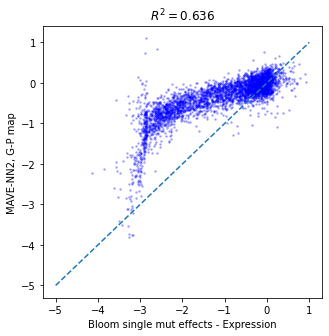

In [38]:
plt.figure(figsize=(5,5))
Rsq = np.corrcoef(bloom_exp_df.fillna(0).values.ravel(),theta_raw_df.fillna(0).values.ravel())[0,1]**2
#Rsq = np.corrcoef(bloom_exp_df.values, logo.df.values)[0,1]**2
#plt.scatter(theta_raw_df.values, -logo.df.values,s=5,alpha=0.25,color='red')
plt.scatter(bloom_exp_df.values, 2*theta_raw_df.values,s=2.5,alpha=0.25,color='blue')

#lims = [-3,1]
plt.plot(lims,lims,'--')
plt.xlabel('Bloom single mut effects - Expression')
plt.title(f'$R^2 = {Rsq:.3f}$')
plt.ylabel('MAVE-NN2, G-P map')

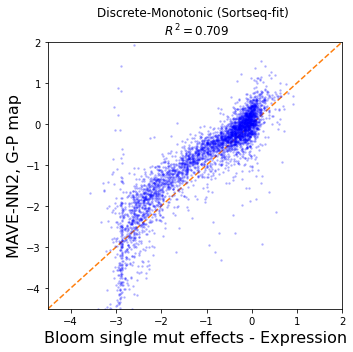

In [86]:
theta_lc = gpmap.get_theta(model,gauge='consensus')['theta_lc']
theta_lc_consensus_df = pd.DataFrame(theta_lc,columns=alphabet)

plt.figure(figsize=(5,5))
Rsq = np.corrcoef(bloom_exp_df.fillna(0).values.ravel(),theta_lc_consensus_df.fillna(0).values.ravel())[0,1]**2
#Rsq = np.corrcoef(bloom_exp_df.values, logo.df.values)[0,1]**2
#plt.scatter(theta_raw_df.values, -logo.df.values,s=5,alpha=0.25,color='red')
plt.scatter(bloom_exp_df.values.ravel(), 5.2*theta_lc_consensus_df.values.ravel(),s=2.5,alpha=0.2,color='blue')

lims = [-4.5,2]
plt.plot(lims,lims,'--',color='C1',zorder=-2)
plt.xlabel('Bloom single mut effects - Expression',fontsize=16)
plt.title(f'Discrete-Monotonic (Sortseq-fit) \n $R^2 = {Rsq:.3f}$')
plt.xlim(lims)
plt.ylim(lims)
plt.ylabel('MAVE-NN2, G-P map',fontsize=16)
plt.tight_layout()
plt.savefig('mavenn_bloom_expression_comparison.png',dpi=200,bbox_inches='tight')

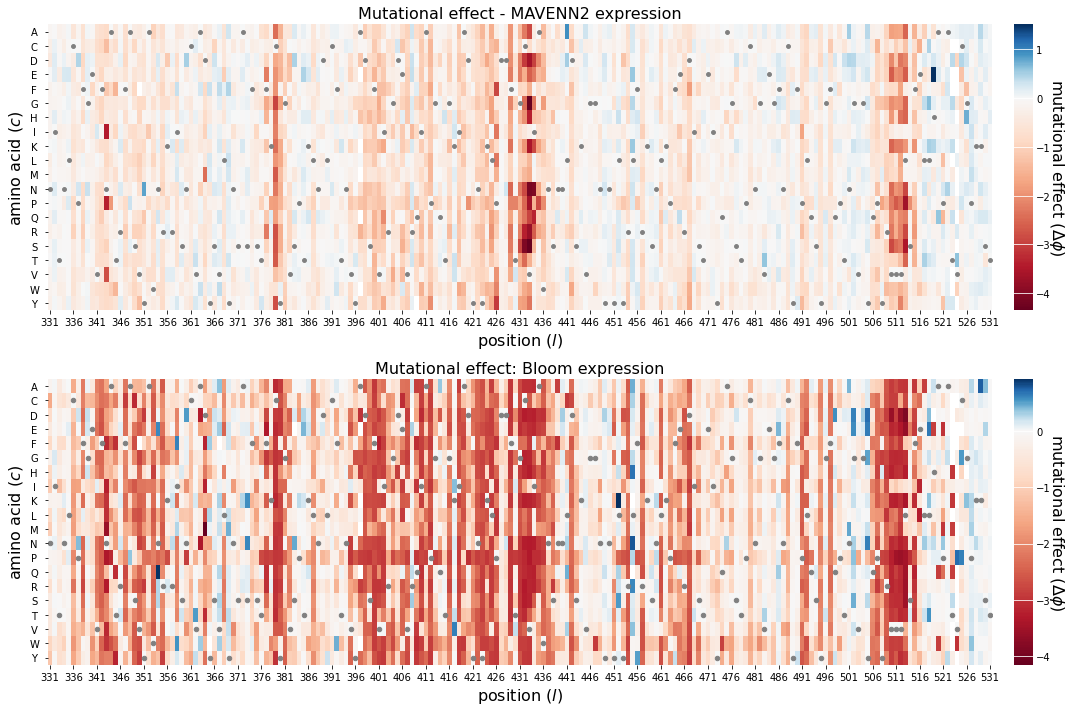

In [91]:

# Create figure
fig, axs = plt.subplots(2,1, figsize=(15,10))

# Draw heatmap
ax = axs[0]

heatmap_ax, cb = mavenn.heatmap(ax=ax,
                                values=2.2*theta_lc,
                                alphabet=alphabet,
                                seq=model.x_stats['consensus_seq'],
                                seq_kwargs={'c':'gray', 's':15},
                                cmap='RdBu',
                                cbar=True,
                                cmap_size='2%',
                                cmap_pad=.3,
                                ccenter=0)
# Style heatmap (can be different between two dataset)
#heatmap_ax.set_xticks()
heatmap_ax.tick_params(axis='y', which='major', pad=10)
heatmap_ax.set_xlabel('position ($l$)',fontsize=16)
heatmap_ax.set_ylabel('amino acid ($c$)',fontsize=16)
heatmap_ax.set_title(f'Mutational effect - MAVENN2 expression',fontsize=16)
heatmap_ax.set_xticks(np.arange(0,201,5))
heatmap_ax.set_xticklabels([f'{x}' for x in range(331,531+1,5)])

# Style colorbar
cb.outline.set_visible(False)
cb.ax.tick_params(direction='in', size=20, color='white')
cb.set_label('mutational effect ($\Delta \phi$)', labelpad=5, rotation=-90, ha='center', va='center',fontsize=16)

# Adjust figure and show
#fig.tight_layout(w_pad=5)
#fig.savefig('ace2rbd_g-p_map_mpa_sortseq_only_heatmap.png',dpi=300,bbox_inches='tight')

bloom_exp_df
# Create figure
#fig, ax = plt.subplots(1,1, figsize=(15,5))

# Draw heatmap
ax = axs[1]

heatmap_ax, cb = mavenn.heatmap(ax=ax,
                                values=bloom_exp_df.values,
                                alphabet=alphabet,
                                seq=model.x_stats['consensus_seq'],
                                seq_kwargs={'c':'gray', 's':20,'marker':'o'},
                                cmap='RdBu',
                                cbar=True,
                                #clim = [-4.5,1],
                                cmap_size='2%',
                                cmap_pad=.3,
                                ccenter=0)
# Style heatmap (can be different between two dataset)
#heatmap_ax.set_xticks()
heatmap_ax.tick_params(axis='y', which='major', pad=10)
heatmap_ax.set_xlabel('position ($l$)',fontsize=16)
heatmap_ax.set_ylabel('amino acid ($c$)',fontsize=16)
heatmap_ax.set_title(f'Mutational effect: Bloom expression',fontsize=16)

heatmap_ax.set_xticks(np.arange(0,201,5))
heatmap_ax.set_xticklabels([f'{x}' for x in range(331,531+1,5)])

# Style colorbar
cb.outline.set_visible(False)
cb.ax.tick_params(direction='in', size=20, color='white')
cb.set_label('mutational effect ($\Delta \phi$)', labelpad=5, rotation=-90, ha='center', va='center',fontsize=16)

# Adjust figure and show
fig.tight_layout(w_pad=5)
fig.savefig('ace2rbd_g-p_map_discrete_monotonic_sortseq_only_heatmap.png',dpi=300,bbox_inches='tight')

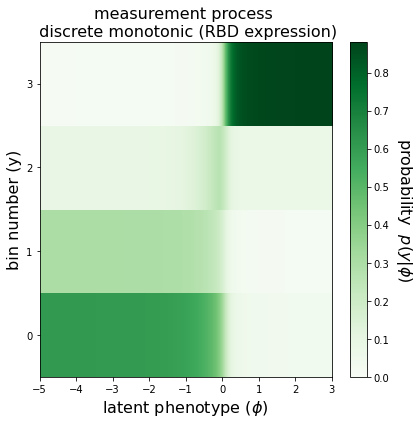

In [84]:
# Create grid in phi space
phi_lim = [-5, 3]
phi_grid = np.linspace(phi_lim[0], phi_lim[1], 1000)

# Create array of allowable y values
Y = mp_mpa.Y    # Y = number of bins
y_lim = [-.5, Y-.5]
y_all = range(Y)

# Compute matrix of p(y|phi) values
measurement_process = mp_mpa.p_of_y_given_phi(y_all, phi_grid)


# Create figure with two panels
fig, ax = plt.subplots(1,1,figsize=[6,6])

# Right panel: draw measurement process as heatmap
im = ax.imshow(measurement_process,
               cmap='Greens',
               extent=phi_lim+y_lim,
               vmin=0,
               origin='lower',
               interpolation='nearest',
               aspect="auto")
ax.set_yticks(y_all)
ax.set_ylabel('bin number (y)',fontsize=16)
ax.set_xlabel('latent phenotype ($\phi$)',fontsize=16)
ax.set_title('measurement process \n discrete monotonic (RBD expression)',fontsize=16)
cb = plt.colorbar(im)
cb.set_label('probability  $p(y|\phi)$', rotation=-90, va="bottom",fontsize=16)
fig.tight_layout()
fig.savefig('ace2rbd_mpa_measurment_prcoess_sortseq_only.png',dpi=300,bbox_inches='tight')


In [56]:
np.save('sortseq_gpmap_monotonic_agnostic',gpmap.get_theta(model,gauge='uniform')['theta_lc'])
#np.save('sortseq_gpmap_discrete_agnostic',theta.ravel())

In [78]:
np.save('sortseq_gpmap_monotonic_agnostic_consensus',
        5.2*gpmap.get_theta(model,gauge='consensus')['theta_lc'].ravel())